# Analyse exploratoire

**Problématique de la ville de Seattle**  
Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

**Votre mission**  
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Faire bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mettre en place une évaluation rigoureuse des performances de la régression, et optimiser les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Livrables attendus**  
- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Le code (ou un notebook) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance.

**Compétences évaluées**  
- Mettre en place le modèle d'apprentissage supervisé adapté au problème métier
- Évaluer les performances d’un modèle d'apprentissage supervisé
- Adapter les hyperparamètres d'un algorithme d'apprentissage supervisé afin de l'améliorer
- Transformer les variables pertinentes d'un modèle d'apprentissage supervisé

# Sommaire

__[I. Chargement et nettoyage des données](#I.-Chargement-et-nettoyage-des-données)__

__[II. Analyse exploratoire](#II.-Analyse-exploratoire)__\
[II.1 Variables qualitatives et variables quantitatives](#II.1-Variables-qualitatives-et-variables-quantitatives)\
[II.2 Variables quantitatives](#II.2-Variables-quantitatives)\
[II.2.1 Distribution des variables quantitatives](#II.2.1-Distribution-des-variables-quantitatives)\
[II.2.2 outliers](#II.2.2-outliers)\
[II.2.3 feature engineering](#II.2.3-feature-engineering)\
[II.2.4 Etude des corrélations](#II.2.4-Etude-des-corrélations)\
[II.2.4.i Variables cibles](#II.2.4.i-Variables-cibles)\
[II.2.4.ii Prédicteurs](#II.2.4.ii-Prédicteurs)\
[II.3 Variables catégorielles](#II.3-Variables-catégorielles)\
[II.3.1 Nettoyage des variables catégorielles](#II.3.1-Nettoyage-des-variables-catégorielles)\
[II.3.2 Etude des corrélations](#II.3.2-Etude-des-corrélations)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import json

# I. Chargement et nettoyage des données

In [2]:
# Chargement des deux datasets
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")

On souhaiter fusionner les deux tables, mais l'indicateur Location dans la table 2015 est absent de la table 2016, et en revanche les indicateurs Latitude, Longitude, Address, City, State et Zipcode sont absents de la table 2015 et présents dans 2016.

Par ailleurs, dans la table 2015, les valeurs de Zip Codes semblent être générées automatiquement - on écarte cette variable du jeu de données

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

In [3]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)

loc = data2015.columns.get_loc("Location")
data2015.drop(columns="Location", inplace=True)

# nouveau dataframe à partir des colonnes extraites
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) 

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

# On retire Zip Codes
data2015.drop(columns="Zip Codes", inplace=True)

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

In [4]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State", "zip":"ZipCode"}, inplace=True)

**Fusion des deux datasets en un dataset global**

In [5]:
# création du dataset global
raw_data = pd.concat([data2015, data2016], join="outer")

# Récupération de la liste de colonnes sous forme de Series
raw_data_cols = pd.Series(raw_data.columns, name="data_cols")

On effectue un premier tri des variables, en écartant d'emblée celles qui semblent le moins pertinentes, et celles qui constituent un risque de fuite de données (SiteEUI, SiteEUIWN, SiteEnergyUseWN, GHGEmissionsIntensity) ou qui ne correspondent pas au cahier des charges (données du permis d'exploitation commercial), comme SourceEUI, SourceEUIWN. On garde en revanche les variables Electricity, NaturalGas, SteamUse comme suggéré.

In [6]:
to_drop_index = [0, #OSEBuildingID 
                 *range(4, 14), # PropertyName, TaxParcelIdentificationNumber --> Latitude, City, State, 
                                # ZipCode, CouncilDistrictCode, Neighborhood
                 20, # ListOfAllPropertyUseTypes 
                 27, # YearsENERGYSTARCertified
                 #28, # ENERGYSTARScore
                 #30, # SiteEUIWN
                 #32, # SourceEUIWN
                 #34, # SiteEnergyUseWN
                 36, # Electricity (kWh)
                 38, # NaturalGas (therms)
                 *range(43, 46), # DefaultData, Comments, ComplianceStatus
                 *range(47,51)] # 2010 Census Tracts, Seattle Police..., City Council, SPD Beats, ZipCode
to_drop_cols = raw_data_cols.iloc[to_drop_index]
raw_data = raw_data.drop(columns=to_drop_cols)

Il y a un certain nombre de valeurs manquantes dans SecondLargestPropertyUseType, ThirdLargestPropertyUseType,
SecondLargest\[...\]GFA, ThirdLargest\[...\]GFA.
Dans les variables catégorielles, on remplace NaN par "None". Sur les variables quantitatives associées, 
on va remplacer les NaN par 0

In [7]:
raw_data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["SecondLargestPropertyUseType"].fillna("None", inplace=True)
raw_data["ThirdLargestPropertyUseType"].fillna("None", inplace=True)

La colonne OtherFuelUse(kBtu) ne contient pratiquement que des valeurs nulles: on la supprime. 
On supprime également les lignes contenant des valeurs manquantes.

In [8]:
raw_data.drop(columns='OtherFuelUse(kBtu)', inplace=True)
raw_data.dropna(subset=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], how="any", inplace=True)
raw_data.dropna(subset=["LargestPropertyUseType"],inplace=True)
raw_data.dropna(subset=["NumberofBuildings", "NumberofFloors"], how="any", inplace=True)

On supprime également toutes les entrées correspondant aux bâtiments résidentiels (conformément aux instructions)

In [9]:
# Suppression des bâtiments résidentiels
multifam_indices = raw_data.loc[raw_data["BuildingType"].isin(['Multifamily MR (5-9)', 
                                                 'Multifamily LR (1-4)',
                                                 'Multifamily HR (10+)' ])].index
raw_data.drop(index=multifam_indices, inplace=True)

In [10]:
# enregistrement du jeu de données dans un fichier csv
raw_data.to_csv("./raw_data.csv", index_label=False)

# II. Analyse exploratoire

## II.1 Séparation des variables qualitatives et des variables quantitatives

In [11]:
# Chargement du jeu de données nettoyé
raw_data = pd.read_csv("./raw_data.csv")

# On sépare le dataframe en deux: les colonnes numériques et les colonnes "object"
# Variables numériques
mask = raw_data.dtypes!="object"
numerical_features = mask[mask].index

# variables "object"
mask = raw_data.dtypes=="object"
object_features = mask[mask].index

# Les colonnes DataYear, YearBuilt sont des variables catégorielles en réalité
num_categorical = pd.Index(["DataYear",
                            "YearBuilt"])

# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = object_features.append(num_categorical)

# On crée de même l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if c not in categorical_features])

## II.2 Variables quantitatives

### II.2.1 Distribution des variables quantitatives

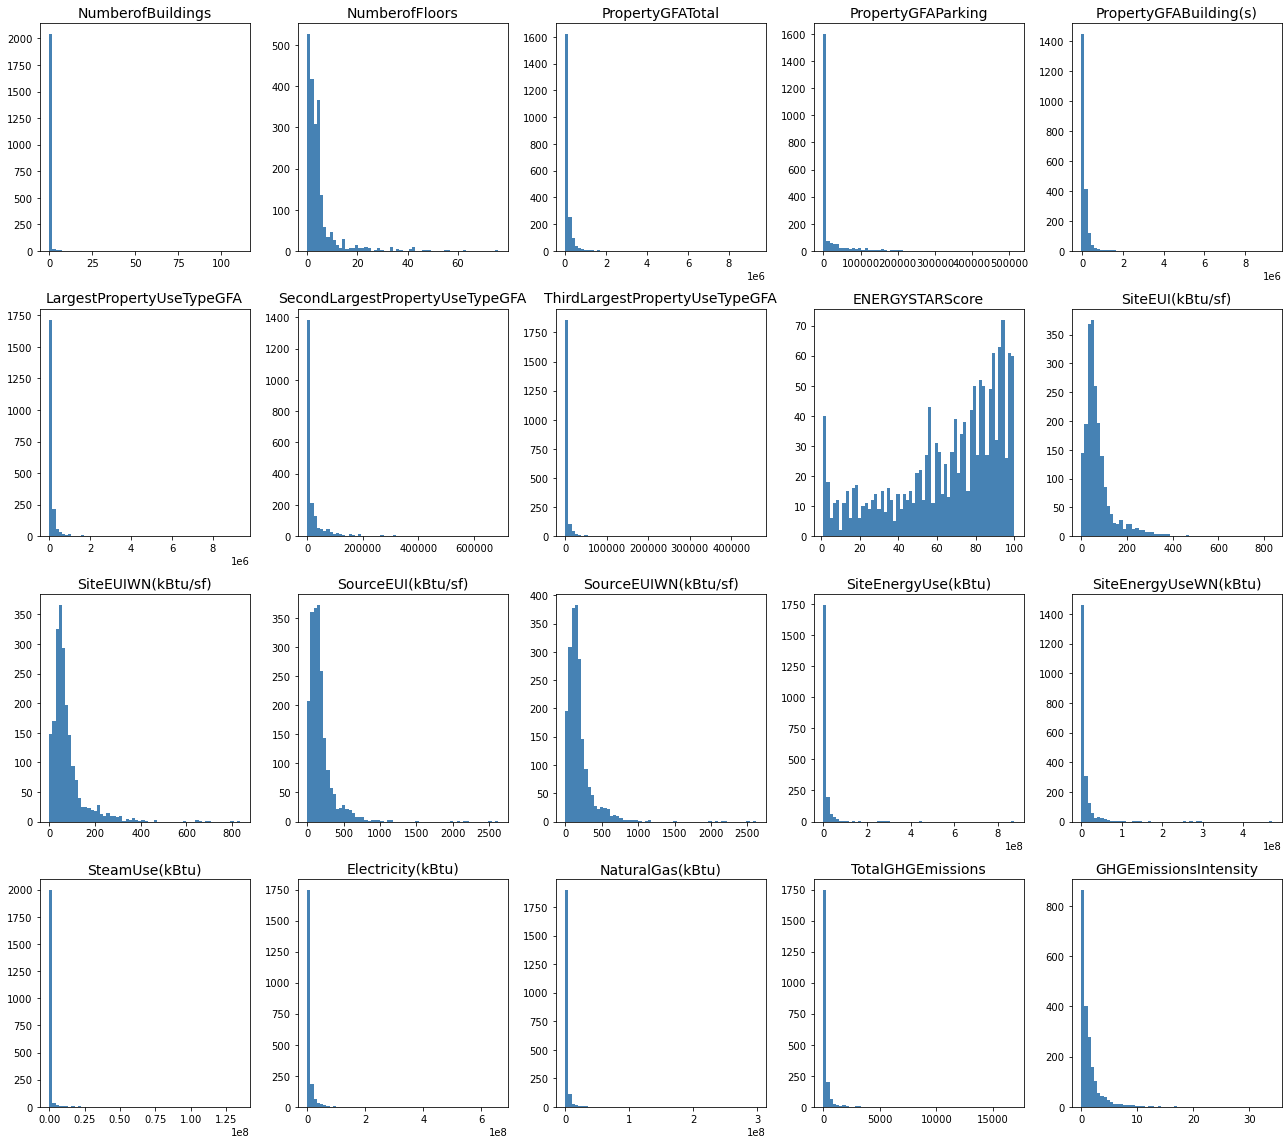

In [12]:
fig = plt.figure(figsize=(18, 16))
for feat_idx, feat in enumerate(quantitative_features):
    ax = fig.add_subplot(4,5, (feat_idx+1))
    h = ax.hist(raw_data[feat], bins=5*int(1+np.log2(raw_data.shape[0])), color = 'steelblue', density=False, edgecolor='none')
    ax.set_title(feat, fontsize=14)
    plt.tight_layout()

On remarque que les données sont très dispersées. On observe également des échelles de variation très différentes d'une variable à l'autre. On a par ailleurs des outliers, et des valeurs à 0 (NumberofBuildings, TotalGHGEmission, LargestPropertyUseTypeGFA etc.) qui sont probablement des valeurs aberrantes.

### II.2.2 outliers

Pour le traitement des outliers on va utiliser à profit la colonne "Outlier", effectuer des filtrages "à la main", et utiliser la relation qui existe entre les variables SiteEUI et SiteEnergyUse

[Comment calculer les différents EUI à partir de l'énergie totale](https://energystar-mesa.force.com/PortfolioManager/s/article/Which-GFA-is-used-to-compute-EUI-with-or-without-parking-1600088537613)

R2 avant nettoyage: 0.90
R2 après nettoyage: 0.99


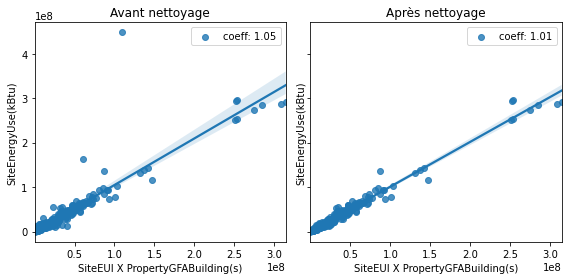

In [13]:
### 1. traitement par la colonne "outliers" ###

# On commence par regrouper les outliers dans la catégorie "Yes", et les valeurs NaN dans "No"
outlier_yn = raw_data["Outlier"].where(raw_data["Outlier"].notna(), "No")
raw_data["Outlier_yn"] = outlier_yn
raw_data["Outlier_yn"] = raw_data["Outlier_yn"].apply(lambda x: "Yes" if x!="No" else x)

# On ne garde que les non-outliers
raw_data = raw_data.loc[raw_data.Outlier_yn=="No"]

# On supprime les colonnes "Outlier" et "Outlier_yn" qui ne sont plus utiles
raw_data.drop(columns=["Outlier", "Outlier_yn"], inplace=True)

# On supprime également cette variables de la liste categorical
categorical_features = categorical_features.drop(["Outlier"])

### 2. Filtrage "à la main"###

# On corrige les valeurs négatives de PropertyGFABuilding(s)
m = raw_data["PropertyGFABuilding(s)"] <= 0
raw_data["PropertyGFABuilding(s)"].mask(m, -raw_data["PropertyGFABuilding(s)"], inplace=True)

# On retire les valeurs de TotalGHGEmissions, NumberofBuildings qui sont négatives ou nulles, et
# les valeurs de SiteEnergyUse(kBtu) qui sont nulles (nécessaire pour prendre le logarithme des variables
# cibles en vue des prédictions)
d = raw_data.query("TotalGHGEmissions<=0 or NumberofBuildings<=0 or \
                   NumberofFloors==0 or `SiteEnergyUse(kBtu)`==0").index
raw_data.drop(index=d, inplace=True)

# Il y a un bâtiment de 99 étages dont les émissions sont quasi-nulles: on l'écarte, il s'agit certainement
# d'un outlier.
raw_data = raw_data[raw_data.NumberofFloors<80] 

### 3. Filtrage par la relation linéaire entre SiteEUI et SiteEnergyUse ###

# On cherche à comparer le coefficient de proportionnalité entre SiteEnergyUse et SiteEUI d'une part, et à 
# comparer ce coefficient avec la valeur de PropertyGFABuilding(s)

# Création de la statistique du coefficient de proportionnalité entre SiteEUI et SiteEnergyUse
var = "PropertyGFABuilding(s)"
prop_coef = raw_data["SiteEnergyUse(kBtu)"]/raw_data["SiteEUI(kBtu/sf)"]
stat = prop_coef/raw_data[var]
stat = pd.DataFrame(stat)

# On cherche à écarter les 2% de valeurs extrêmes
perc = 2
low, high = perc/200, 1-perc/200
conf_low, conf_high = stat.quantile(low).values[0], stat.quantile(high).values[0]

# Récupération des index des outliers
outlier_index = raw_data.loc[
    (raw_data["SiteEnergyUse(kBtu)"]>conf_high*raw_data[var]*raw_data["SiteEUI(kBtu/sf)"])
                         | (raw_data["SiteEnergyUse(kBtu)"]<conf_low*raw_data["SiteEUI(kBtu/sf)"]*raw_data[var])].index

# On écarte les outliers du jeu de données
d = raw_data.copy()
d.drop(index=outlier_index, inplace=True)

## Comparaisons avant/après nettoyage et affichage des graphes associés. ##
# Quelques définitions
SiteEnergyUse = d[var]*d["SiteEUI(kBtu/sf)"]
SiteEnergyUse_raw = raw_data[var]*raw_data["SiteEUI(kBtu/sf)"]
X = SiteEnergyUse.to_numpy().reshape(-1, 1)
y = d["SiteEnergyUse(kBtu)"].to_numpy()
X_r = SiteEnergyUse_raw.to_numpy().reshape(-1, 1)
y_r = raw_data["SiteEnergyUse(kBtu)"].to_numpy()

# Régressions linéaires sur chaque jeu de données (avant et après nettoyage):
# On utilise l'api statsmodel pour calculer le r2 avec et sans les outliers
import statsmodels.api as sm
model = sm.OLS(y, X)
model_r = sm.OLS(y_r, X_r)
results, results_r = model.fit(), model_r.fit()
print("R2 avant nettoyage: {:.2f}".format(results_r.rsquared))
print("R2 après nettoyage: {:.2f}".format(results.rsquared))

# Affichage des relations avant (gauche) et après (droite) nettoyage
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)
sns.regplot(x=SiteEnergyUse_raw, y=raw_data["SiteEnergyUse(kBtu)"], 
            label='coeff: {:.2f}'.format(results_r.params[0]),
            ax=ax1)
ax1.legend()
sns.regplot(x=SiteEnergyUse, 
            y=d["SiteEnergyUse(kBtu)"], 
            label='coeff: {:.2f}'.format(results.params[0]), 
            ax=ax2)
ax2.legend()
for ax, ti in zip([ax1, ax2], ["Avant nettoyage", "Après nettoyage"]):
    ax.set_xlabel(f"SiteEUI X {var}")
    ax.set_title(ti)
plt.tight_layout()
plt.show()

# création d'un nouveau dataframe
data = d
data.to_csv("./data.csv", index_label=False)



On termine notre inspection des variables quantitatives avec NumberofFloors, NumberofBuildings, ENERGYSTARScore. Ces trois variables ont en commun d'être de type int64 et de posséder peu de modalités relativement à la taille de  la population.

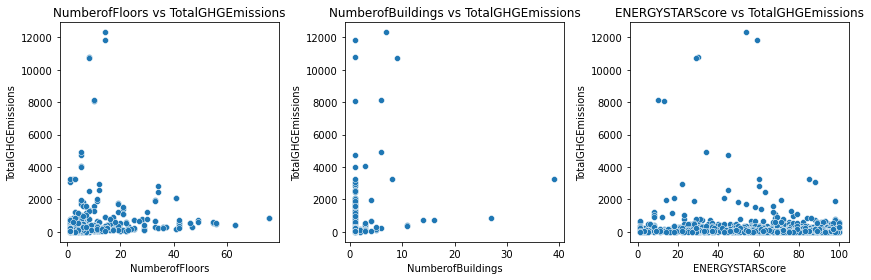

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
for ax, var in zip([ax1, ax2, ax3], ["NumberofFloors", "NumberofBuildings", "ENERGYSTARScore"]):
    sns.scatterplot(data=data,
                x=var,
                y="TotalGHGEmissions",
                ax=ax)
    ax.set_title(f"{var} vs TotalGHGEmissions")
plt.tight_layout()
plt.show()

Regroupons les valeurs par modalités, afin d'afficher les valeurs moyennes de TotalGHGEmissions en fonction des modalités. Ceci afin de voir si il y existe une dépendance entre ces variables.

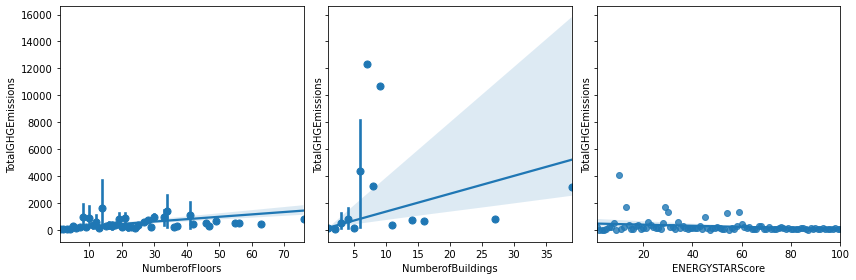


TotalGHGEmissions vs ENERGYSTARScore (zoom):


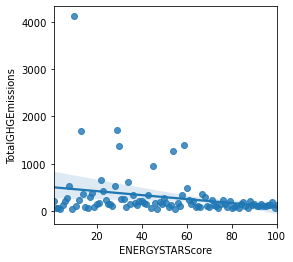

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
sns.regplot(x="NumberofFloors", y="TotalGHGEmissions", data=data, x_estimator=np.mean, ax=ax1)
sns.regplot(x="NumberofBuildings", y="TotalGHGEmissions", data=data, x_estimator=np.mean, ax=ax2)

# Pour affichage de TotalGHGEmissions vs ENERGYSTARScore sans les barres d'erreur pour des raisons de lisibilité
gb = data.groupby("ENERGYSTARScore")
X = sorted(data.loc[data.ENERGYSTARScore.notna(), "ENERGYSTARScore"].unique())
ys = gb["TotalGHGEmissions"].mean().sort_index() 
sns.regplot(x=X, y=ys, data=data, ax=ax3)
ax3.set_xlabel("ENERGYSTARScore")
plt.tight_layout()
plt.show()

print("")
print("TotalGHGEmissions vs ENERGYSTARScore (zoom):")
# Zoom pour affichage de TotalGHGEmissions versus ENERGYSTARScore
fig, ax = plt.subplots(figsize=(4, 4), sharey=True)
sns.regplot(x=X, y=ys, data=data, ax=ax)
ax.set_xlabel("ENERGYSTARScore")
plt.show()

Il y a clairement une dépendance de TotalGHGEmissions sur chacune de ces trois variables. En revanche, là où cette association est très marquée pour NumberofBuildings, elle l'est moins pour NumberofFloors et encore moins - voire quasiment inexistante - pour ENERGYSTARScore.

ENERGYSTARScore prend en compte "the information you enter about your building, such as its size, location, number of occupants, number of PCs, etc" d'après les informations trouvées sur le site energystar.gov. Par ailleurs,  "The following steps are used to compute the score for an individual property:

1. Enter data into Portfolio Manager
2. Compute actual source energy use intensity
3. Compute the predicted source energy use intensity
4. Compute an efficiency ratio comparing the actual use with the predicted use
5. Assign a score based on how the ratio compares with the national distribution"

Enfin, "All of the calculations are based on source energy and account for the impact of weather variations, as well as changes in key property use details."

Les grandeurs pertinentes à mettre en regard de ENERGYSTARScore sont donc les variables "Intensity", c'est-à-dire celles renseignant sur l'énergie consommée, ou les emissions générées par unité de surface. La dépendance entre TotalGHGEMissions et ENERGYSTARScore intervient donc notamment via le coefficient codé dans la variable PropertyGFABuilding(s). Ci-dessous, on explore la relation qui existe entre ENERGYSTARScore et GHGEmissionsIntensity d'une part, et ENERGYSTARScore et SourceEUIWN d'aure part. Encore une fois, on affiche la valeur moyenne des GHGEmissionsIntensity et SourceEUIWN pour chaque valeur d'ENERGYSTARScore

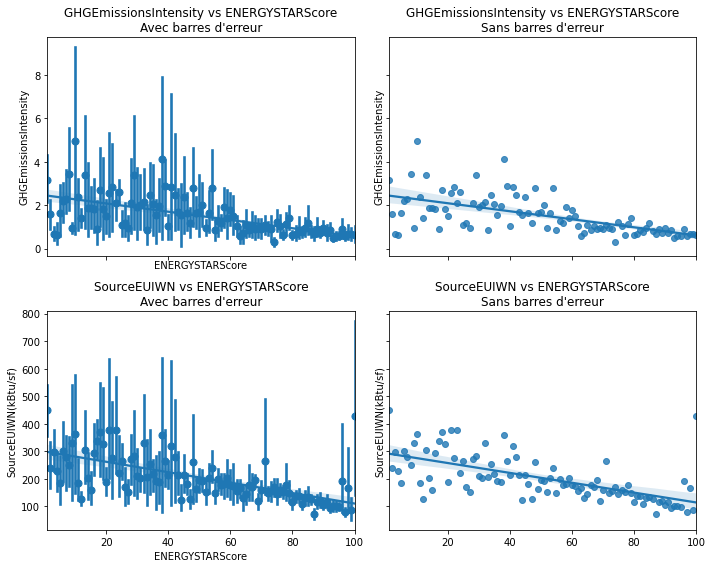

In [16]:
gb = data.groupby("ENERGYSTARScore")
y = gb["GHGEmissionsIntensity"].mean().sort_index()
X = sorted(data.loc[data.ENERGYSTARScore.notna(), "ENERGYSTARScore"].unique())
ys = gb["SourceEUIWN(kBtu/sf)"].mean().sort_index() 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey='row', sharex='col')
sns.regplot(x="ENERGYSTARScore", y="GHGEmissionsIntensity", data=data, x_estimator=np.mean, ax=ax1)
sns.regplot(x=X, y=y,
            #x_estimator=np.mean, 
            ax=ax2
           )
ax1.set_xlabel("ENERGYSTARScore")
ax1.set_title("GHGEmissionsIntensity vs ENERGYSTARScore\nAvec barres d'erreur")
ax2.set_title("GHGEmissionsIntensity vs ENERGYSTARScore\nSans barres d'erreur")

sns.regplot(x="ENERGYSTARScore", y="SourceEUIWN(kBtu/sf)", data=data, x_estimator=np.mean, ax=ax3)
sns.regplot(x=X, y=ys,
            #x_estimator=np.mean, 
            ax=ax4
           )
ax3.set_xlabel("ENERGYSTARScore")
ax3.set_title("SourceEUIWN vs ENERGYSTARScore\nAvec barres d'erreur")
ax4.set_title("SourceEUIWN vs ENERGYSTARScore\nSans barres d'erreur")
plt.tight_layout()
plt.show()

### II.2.3 feature engineering

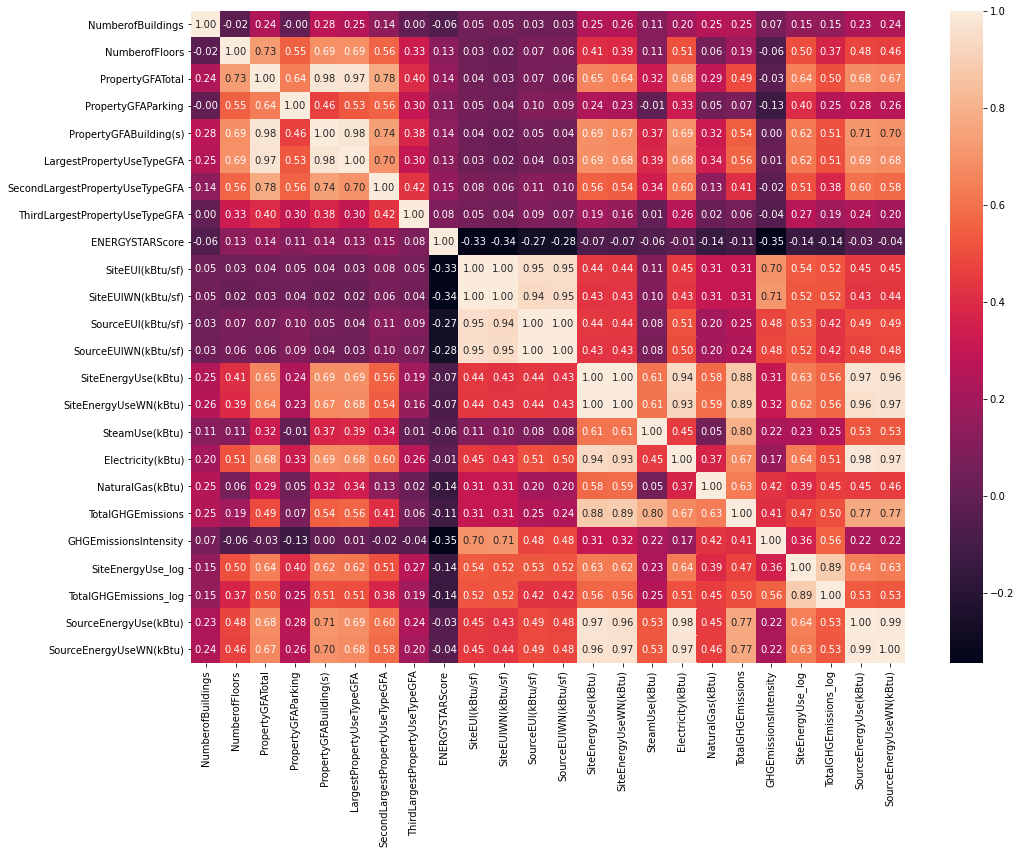

In [17]:
# chargement des données (dé-commenter si nécessaire)
#data = pd.read_csv("./data.csv")

# On prend le log des variables cibles, et on ajoute les nouvelles variables à la liste des variables 
# quantitatives.
data["SiteEnergyUse_log"] = data["SiteEnergyUse(kBtu)"].apply(np.log10)
data["TotalGHGEmissions_log"] = data["TotalGHGEmissions"].apply(np.log10)
targets = pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"])
quantitative_features = quantitative_features.append(targets)

# Création des variables SourceEnergyUseWN et SourceEnergyUse(kBtu), et ajout à la liste des variables 
# quantitatives.
data["SourceEnergyUseWN(kBtu)"] = data["SourceEUIWN(kBtu/sf)"]*data["PropertyGFABuilding(s)"]
data["SourceEnergyUse(kBtu)"] = data["SourceEUI(kBtu/sf)"]*data["PropertyGFABuilding(s)"]
quantitative_features = quantitative_features.append(pd.Index(["SourceEnergyUse(kBtu)", "SourceEnergyUseWN(kBtu)"]))

# Etude des corrélations
corr = data[quantitative_features].corr() # pearson
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

* On a de fortes corrélations entre les variables "PropertyGFATotal", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA": on va réaliser une ACP sur ces variables.

Par ailleurs,
* Ces variables sont elles-mêmes fortement corrélées à Electricity(kBtu)
* Electricity(kBtu) très fortement corrélée à SiteEnergyUSe
* Electricity, Steam, NaturalGas fortement corrélées à TotalGHGEmissions
* "L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées)."
$\rightarrow$On va donc créer ces nouvelles variables.

**1. Création des nouvelles variables**

In [18]:
# Création des variables informant sur la nature et la proportion des sources d'énergie.
data["Electricity_ratio"] = data[["Electricity(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)
data["NaturalGas_ratio"] = data[["NaturalGas(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)
data["Steam_ratio"] = data[["SteamUse(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)

# Ajout des nouvelles variables à la liste des variables quantitatives.
quantitative_features = quantitative_features.append(pd.Index(["Electricity_ratio", "NaturalGas_ratio", "Steam_ratio"]))

**ACP sur les variables quantitatives "GFA"**

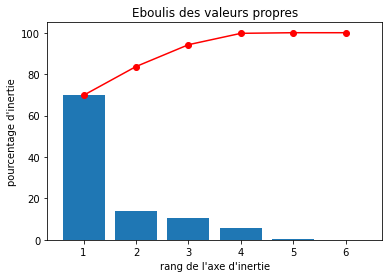


--> On pourra se contenter des 4 premières variables lors de la prédiction.

Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:


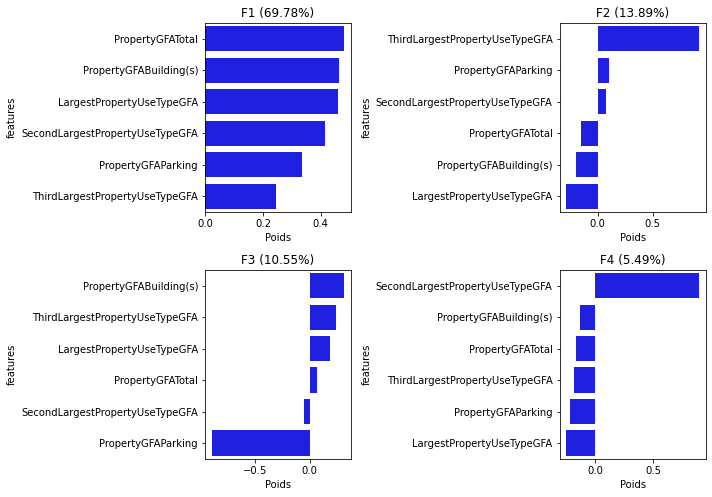

In [19]:
### ACP sur les variables liées à la surface au sol des bâtiments.###
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from functions import *

# choix du nombre de composantes à calculer
#n_comp = 4

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)",
                 "LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",
                 "ThirdLargestPropertyUseTypeGFA"
                ]]

## préparation des données pour l'ACP ##
X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centrage et Réduction
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## Calcul des composantes principales ##
pca = PCA()
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

print("")
print("--> On pourra se contenter des 4 premières variables lors de la prédiction.\n")

# Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes
pcacomponents = pd.DataFrame(data=np.transpose(pca.components_), 
                             columns=["F1", "F2", "F3", "F4", "F5", "F6"],
                             index=features)

pcacomponents = pcacomponents.reset_index().rename(columns={"index":"features"})

print("Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:")
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(pcacomponents.columns[1:5]):
    ax = fig.add_subplot(3, 2, i+1)
    sns.barplot(data=pcacomponents.sort_values(by=c, ascending=False),
                x=c,
                y='features',
                color="b",
               ax=ax
               )
    ax.set_title("{} ({:.2f}%)".format(c, pca.explained_variance_ratio_[i]*100))
    ax.set_xlabel("Poids")
    plt.tight_layout()
plt.show()
    

In [20]:
data.to_csv("./data.csv", index_label=False)
with open('./categorical_features.json', 'w') as outfile:
    json.dump(list(categorical_features), outfile)

## II.3 Variables catégorielles

### II.3.1 Nettoyage des variables catégorielles

Combien de modalités pour chaque variable catégorielle?

In [21]:
data = pd.read_csv("./data.csv")
with open("./categorical_features.json") as f:
    categorical_features = pd.Index(json.load(f))
    
pd.DataFrame(data={"nombre de modalités":data[categorical_features].nunique()})

,nombre de modalités
BuildingType,5
PrimaryPropertyType,29
LargestPropertyUseType,53
SecondLargestPropertyUseType,46
ThirdLargestPropertyUseType,34
DataYear,2
YearBuilt,112


On commence par définir diverses fonctions qui vont nous aider à analyser les variables catégorielles.

In [22]:
def valuecount_df(var, df):
    counts = df[var].value_counts()
    return pd.DataFrame({"nb_items": counts})

def droplevels(categorical_features, prop_tokeep, df):
    for cat in categorical_features:
        vcounts = df[cat].value_counts()
        nkeep = prop_tokeep*df.shape[0]
        df[cat] = df[cat].apply(lambda x: "Other" 
                                if vcounts[x] <= nkeep
                                else x)
    return df

def mergelevels(categorical_feature, leveltomerge, newlevel, df):
    df[categorical_feature] = df[categorical_feature].apply(lambda x: newlevel if x==leveltomerge
                                                               else x)

def plotlevels(df, var, target, xmin=None, xmax=None, ax=None):
    means = df.groupby(var)[target].mean().sort_values().index
    
    # Applique le style par défaut de Matplotlib.
    import matplotlib as mpl
    boxprops = {'facecolor': 'white',
                'edgecolor': 'black',
                'linestyle': mpl.rc_params()['boxplot.boxprops.linestyle'],
                'linewidth': mpl.rc_params()['boxplot.flierprops.linewidth']}
    capprops = {'color': 'black', 'linestyle': '-','linewidth': 1.0}
    medianprops = {'color': 'C1', 'linestyle': '-', 'linewidth': 1.0}
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
    sns.boxplot(y=var, x=target, data=df, ax=ax1, orient="h", showfliers=False, showmeans=True,
                order=means, 
                boxprops=boxprops,
                medianprops=medianprops,
                capprops=capprops,
               )
    sns.countplot(data=df, y=var, orient="h", ax=ax2, order=means, color='lightblue')
    try:
        ax1.set_xlim(xmin, xmax)
    except:
        pass
    plt.tight_layout()

import statsmodels.api as sm
from statsmodels.formula.api import ols

def anova(df, quant_var, cat_var, subcat=None):
    model = '{} ~ {}'.format(quant_var, cat_var)
    try:
        mod = ols(model, data=df[df[cat_var].isin(subcat)].dropna(subset=[quant_var, cat_var], how="any")).fit()           
    except:
        mod = ols(model, data=df.dropna(subset=[quant_var, cat_var], how="any")).fit()           
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])

    #print("Résultats de l'ANOVA pour les variables {} et {}:".format(quant_var, cat_var))
    #print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
    #print("Eta-squared: {:.4f}".format(esq_sm))
    
    return aov_table, esq_sm

from scipy.stats import chi2_contingency

def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    
    
    xi_n = measure.sum().sum()
    table = measure/xi_n
    totx = table.sum(axis=0)
    toty = table.sum(axis=1)
    plt.figure(figsize=(18, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
    chi2, pval, dof, chi2_table = chi2_contingency(c.iloc[:-1, :-1])
    
    #plt.figure(figsize=(18, 6))
    #sns.heatmap(chi2_table, annot=chi2_table, fmt=".0f")
    print("coefficient du chi2: {:.0f}".format(chi2))
    print("p-valeur: {}".format(pval))

On a $\approx$ 6200 éléments au total. Comme il y a pour chaque variable beaucoup de modalités ne comportant qu'un très faible nombre d'éléments, on va chercher à fusionner certaines modalités:
* Pour la variables YearBuilt, on va commencer par regrouper les années en décénnies.
* Conformément aux instructions, on supprime toutes les lignes pour lesquelles BuildingType est de type résidentiel (Multifamily Housing)
* Pour les autres variables (BuildingType, PrimaryPropertyType, (-, Second, Third)LargestPropertyUseType), on fusionnera toutes les modalités ainsi formées ayant moins de l'équivalent d'une certaine proportion du jeu de données total (proportion déterminée à travers différents essais-erreurs). Puis, on inspectera les modalités peu représentées, et on fusionnera celles pour lesquelles une fusion a du sens au niveau métier. On considère en effet que les modalités ayant trop peu d'éléments "bruitent" le modèle et augmentent les chances d'overfitting plutôt que d'y apporter de l'information. On regroupera ces modalités dans une modalité plus large "Other".

In [23]:
### Fusions des catégories basées sur les valeurs moyennes ###

# Dataset generated by grouping the levels of the categorical variables using a 5% threshold
d1 = data.copy()

# Pour YearBuilt on commence par regrouper les années en décennies.
yearbuilt_range = d1.YearBuilt.max()-1900 # on compte les décennies en partant de 1900 (et non Yearbuilt.min())
extra_years = yearbuilt_range % 10

# Si les reste de la division euclidienne de yearbuilt_range par 10 est non nul, ajoute 1 au nombre de 
# décennies. exemple: max = 2003, min=1900, yearbuilt_range = 103, extra_years = 3, nb_decades = 11
if extra_years != 0:
    nb_decades = 1 + yearbuilt_range // 10
else:
    nb_decades = yearbuilt_range // 10
    

bins = [1900+i*10 for i in range(int(nb_decades))]
yb_grouped = np.digitize(d1.YearBuilt, bins)
d1.loc[:, "YearBuilt"] = yb_grouped

# en fonction des résultats de prédiction des différents modèles on pourra modifier ce coefficient 
# pour écarter plus ou moins de modalités
p = 0.01
d1 = droplevels(categorical_features.drop('YearBuilt'), p, d1)

Réaffichons les countplots de chaque variables catégorielle pour visualiser le résultat des fusions.

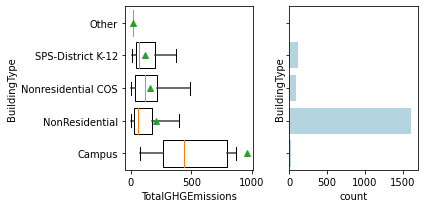

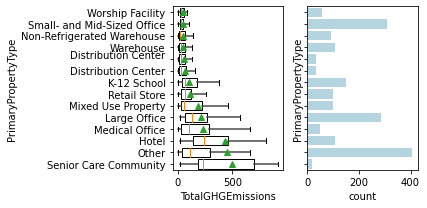

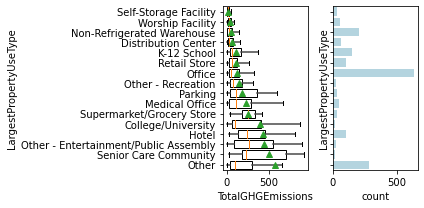

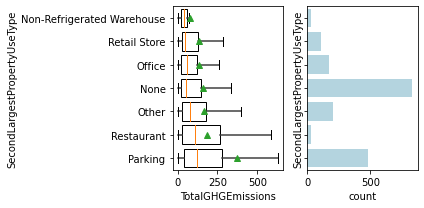

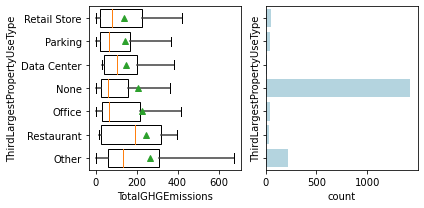

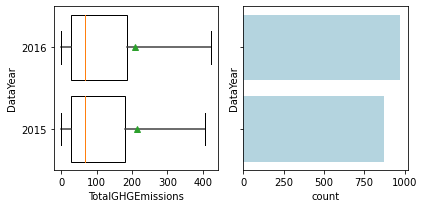

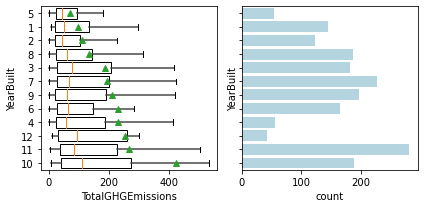

In [24]:
for cat in categorical_features:
    plotlevels(d1, cat, "TotalGHGEmissions")
plt.show()

A partir des graphes ci-dessus, on peut décider de fusionner un certain nombre de modalités - celles qui possèdent très peu d'éléments, et/ou dont les modalités peuvent facilement être regroupées en des catégories plus larges et homogènes, et/ou qui possèdent des valeurs moyennes et écart-types semblables.

Résultat des fusions des modalités appartenant aux diverses variables catégorielles:



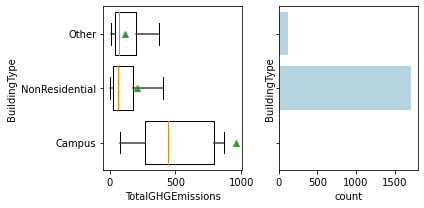

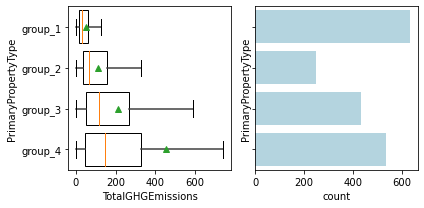

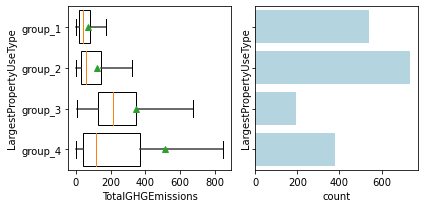

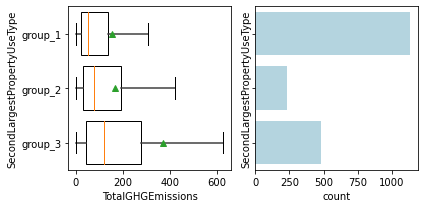

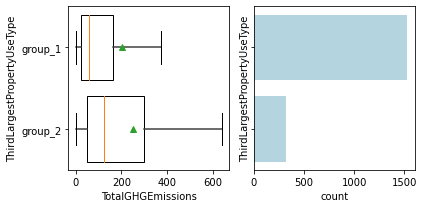

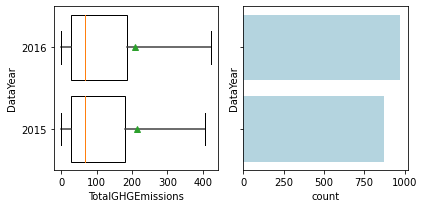

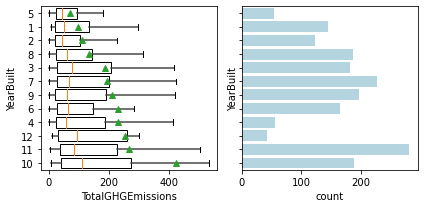

In [25]:
## Fusions des modalités trop peu peuplées/ de valeur moyenne proche ##
# BuildingType
for cat in ["Nonresidential COS"]:
    mergelevels("BuildingType",cat, "NonResidential",d1)
    
mergelevels("BuildingType", "SPS-District K-12", "Other", d1)

# PrimaryPropertyType
for cat in ["Worship Facility", "Small- and Mid-Sized Office", 
            "Warehouse", "Non-Refrigerated Warehouse", "Distribution Center", "Distribution Center\n"]:
    mergelevels("PrimaryPropertyType", cat, "group_1", d1)

for cat in ["K-12 School", "Retail Store"]:
    mergelevels("PrimaryPropertyType", cat, "group_2", d1)

for cat in ["Mixed Use Property", "Large Office", "Medical Office"]:
    mergelevels("PrimaryPropertyType", cat, "group_3", d1)

for cat in ["Senior Care Community", "Hotel", "Other"]:
    mergelevels("PrimaryPropertyType", cat, "group_4", d1)

# LargestPropertyUseType
for cat in ["Worship Facility", "Self-Storage Facility", "Non-Refrigerated Warehouse", 
            "Distribution Center", "K-12 School", "Other - Recreation"]:
    mergelevels("LargestPropertyUseType", cat, "group_1", d1)
    
for cat in ["Retail Store", "Office"]:
    mergelevels("LargestPropertyUseType", cat, "group_2", d1)
    
for cat in ["Supermarket/Grocery Store", "Medical Office", "Hotel"]:
    mergelevels("LargestPropertyUseType", cat, "group_3", d1)
    
for cat in ["Senior Care Community", "College/University", "Other - Entertainment/Public Assembly",
            "Parking", "Other"]:
    mergelevels("LargestPropertyUseType", cat, "group_4", d1)


# SecondLargestPropertyUseType
for cat in ["Non-Refrigerated Warehouse", "Retail Store", "None", "Office"]:
    mergelevels("SecondLargestPropertyUseType", cat, "group_1", d1)

for cat in ["Other", "Restaurant"]:
    mergelevels("SecondLargestPropertyUseType", cat, "group_2", d1)

for cat in ["Parking"]:
    mergelevels("SecondLargestPropertyUseType", cat, "group_3", d1)


#ThirdLargestPropertyUseType
for cat in ["Retail Store", "None", "Parking"]:
    mergelevels("ThirdLargestPropertyUseType", cat, "group_1", d1)

for cat in ["Office", "Data Center", "Other", "Restaurant"]:
    mergelevels("ThirdLargestPropertyUseType", cat, "group_2", d1)

print("Résultat des fusions des modalités appartenant aux diverses variables catégorielles:\n")
for cat in categorical_features:
    plotlevels(d1, cat, "TotalGHGEmissions")
plt.show()

### II.3.2 Etude des corrélations

**Associations entre les cibles et les prédicteurs**

In [26]:
## Calcule les associations des variables avec les cibles (ANOVA) ##
print("-"*80)
print("ANOVA sur les variables catégorielles après fusion des modalités:")
d1.rename(columns={"SiteEnergyUse(kBtu)":"SiteEnergyUse", "SourceEnergyUseWN(kBtu)":"SourceEnergyUseWN"}, inplace=True) # La fonction ANOVA
target1 = "SiteEnergyUse"
target2 = "TotalGHGEmissions"

anovas = {}
for target in [target1, target2]:
    for var in categorical_features:
        aov_table, esq_sm = anova(d1, target, var)
        anovas[var] = [aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"], esq_sm]
    print(f"Associations des variables catégorielles avec {target}")
    print(pd.DataFrame.from_dict(data=anovas,
             columns=["F", "p-value", "eta-squared"],
                       orient="index"
            ).sort_values(by=["eta-squared"], ascending=False))
    print('')

--------------------------------------------------------------------------------
ANOVA sur les variables catégorielles après fusion des modalités:
Associations des variables catégorielles avec SiteEnergyUse
                                      F       p-value  eta-squared
PrimaryPropertyType           51.142914  9.525345e-32     0.076890
LargestPropertyUseType        45.854010  1.413960e-28     0.069491
SecondLargestPropertyUseType  40.240255  7.846895e-18     0.041841
YearBuilt                     43.032659  6.972360e-11     0.022804
BuildingType                  21.276210  7.326841e-10     0.022568
ThirdLargestPropertyUseType   22.949842  1.795763e-06     0.012293
DataYear                       0.084910  7.707834e-01     0.000046

Associations des variables catégorielles avec TotalGHGEmissions
                                      F       p-value  eta-squared
LargestPropertyUseType        39.857045  5.946492e-25     0.060957
PrimaryPropertyType           36.201698  9.938326e-23     

Autre visualisation YearBuilt, de façon à quantifier l'association avec les cibles

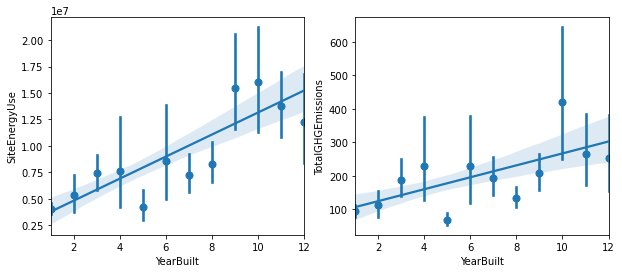

In [27]:
# YearBuilt
d1.YearBuilt = d1.YearBuilt.astype('int64')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(data=d1, x="YearBuilt", y="SiteEnergyUse", x_estimator=np.mean, ax=ax1)
sns.regplot(data=d1, x="YearBuilt", y="TotalGHGEmissions", x_estimator=np.mean, ax=ax2)
plt.show()

Les variables DataYear, BuildingType ne semble pas associée avec SiteEnergyUse. Dans le cas de TotalGHGEmissions, les variables les moins associées sont les mêmes, avec en plus ThirdLargestPropertyUseType. On pourra donc créer deux modèles différents, selon qu'on cherche à prédire l'une ou l'autre cible.

In [28]:
## Création de deux nouveaux jeux de données en écartant la (les) variable(s) dont l'association avec les 
## cibles est inférieure à 1% ##
d1.drop(columns=["DataYear"]).to_csv("./SEUmodel2.csv", index_label=False)
d1.drop(columns=["DataYear", "ThirdLargestPropertyUseType"]).to_csv("./GHGmodel2.csv", index_label=False)

On crée un deuxième ensemble de jeu de données en regroupant les modalités de la variable YearBuilt 
en deux groupes: avant 1970,et après 1970 (8éme décennie)

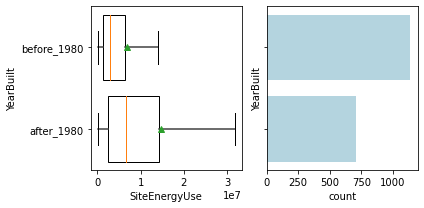

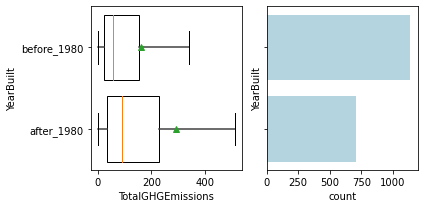

--------------------------------------------------------------------------------
ANOVA sur les variables catégorielles après fusion des modalités:
Associations des variables catégorielles avec SiteEnergyUse
                                      F       p-value  eta-squared
PrimaryPropertyType           51.142914  9.525345e-32     0.076890
LargestPropertyUseType        45.854010  1.413960e-28     0.069491
SecondLargestPropertyUseType  40.240255  7.846895e-18     0.041841
YearBuilt                     52.995919  4.925246e-13     0.027937
BuildingType                  21.276210  7.326841e-10     0.022568
ThirdLargestPropertyUseType   22.949842  1.795763e-06     0.012293
DataYear                       0.084910  7.707834e-01     0.000046

Associations des variables catégorielles avec TotalGHGEmissions
                                      F       p-value  eta-squared
LargestPropertyUseType        39.857045  5.946492e-25     0.060957
PrimaryPropertyType           36.201698  9.938326e-23     

In [29]:
d2 = d1.copy()
for cat in range(9): 
    mergelevels("YearBuilt", cat, "before_1980", d2)
for cat in range(9, d1.YearBuilt.nunique()+1):
    mergelevels("YearBuilt", cat, "after_1980", d2)

for target in ["SiteEnergyUse", "TotalGHGEmissions"]:
    plotlevels(d2, "YearBuilt", target)
    plt.show()

## Calcule les associations des variables avec les cibles (ANOVA) ##
print("-"*80)
print("ANOVA sur les variables catégorielles après fusion des modalités:")
d2.rename(columns={"SiteEnergyUse(kBtu)":"SiteEnergyUse", "SourceEnergyUseWN(kBtu)":"SourceEnergyUseWN"}, inplace=True) # La fonction ANOVA
target1 = "SiteEnergyUse"
target2 = "TotalGHGEmissions"

anovas = {}
for target in [target1, target2]:
    for var in categorical_features:
        aov_table, esq_sm = anova(d2, target, var)
        anovas[var] = [aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"], esq_sm]
    print(f"Associations des variables catégorielles avec {target}")
    print(pd.DataFrame.from_dict(data=anovas,
             columns=["F", "p-value", "eta-squared"],
                       orient="index"
            ).sort_values(by=["eta-squared"], ascending=False))
    print('')

On va maintenant inspecter les associations deux à deux entre les prédicteurs.

In [30]:
from scipy.stats import chi2_contingency

def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    
    
    xi_n = measure.sum().sum()
    table = measure/xi_n
    totx = table.sum(axis=0)
    toty = table.sum(axis=1)
    plt.figure(figsize=(18, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
    chi2, pval, dof, chi2_table = chi2_contingency(c.iloc[:-1, :-1])
    
    #plt.figure(figsize=(18, 6))
    #sns.heatmap(chi2_table, annot=chi2_table, fmt=".0f")
    print("coefficient du chi2: {:.0f}".format(chi2))
    print("p-valeur: {}".format(pval))

On inspecte les associations entre les variables catégorielles. Dans le cas où deux variables catégorielles sont trop dépendantes, on decide de les fusionner (on ne peut pas réaliser d'ACP sur des variables catégorielles). 

coefficient du chi2: 1584
p-valeur: 0.0


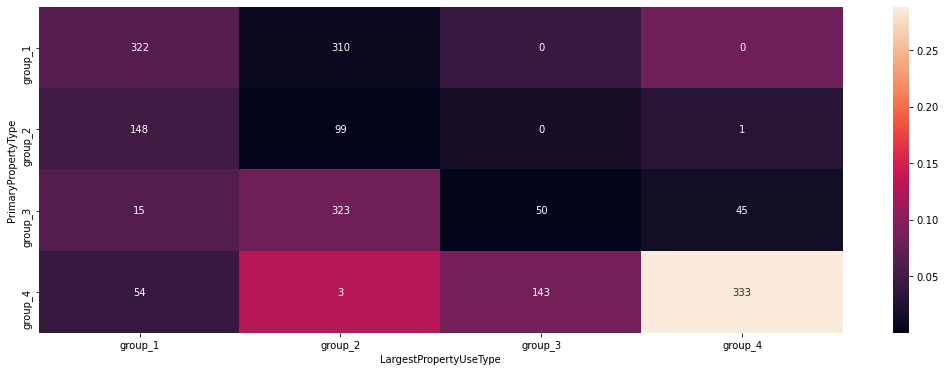

In [31]:
contingence("PrimaryPropertyType", "LargestPropertyUseType", d1)

coefficient du chi2: 348
p-valeur: 4.0185460684606274e-72


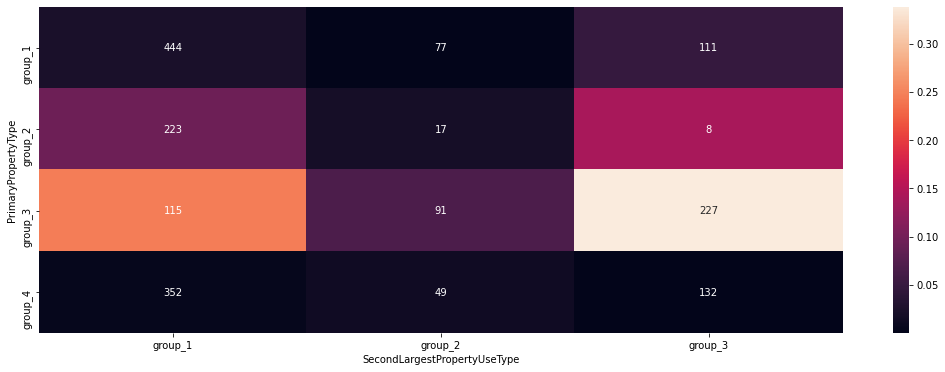

In [32]:
contingence("PrimaryPropertyType", "SecondLargestPropertyUseType", d1)

Forte redondance entre ces deux prédicteurs, et forte similarité dans leur définition même. On décide de fusionner ces deux variables, et on retire PrimaryPropertyType et LargestPropertyUseType du jeu de données

coefficient du chi2: 757
p-valeur: 3.633723022730951e-160


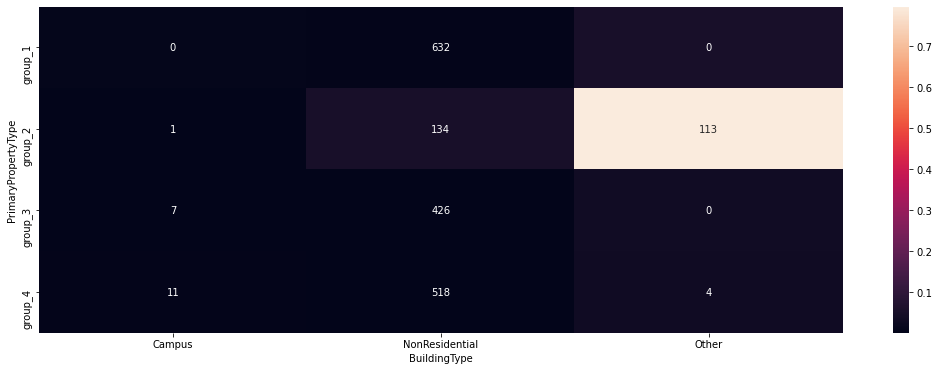

In [33]:
contingence("PrimaryPropertyType","BuildingType", d1)

coefficient du chi2: 270
p-valeur: 5.5331684055450935e-39
coefficient du chi2: 134
p-valeur: 6.103403480752664e-29


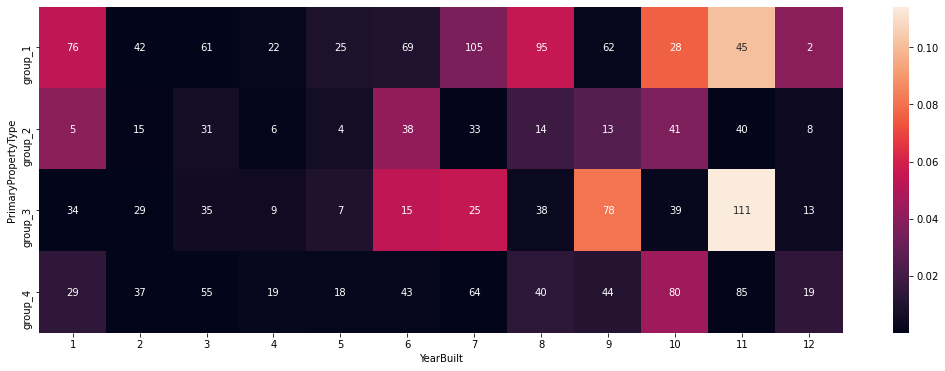

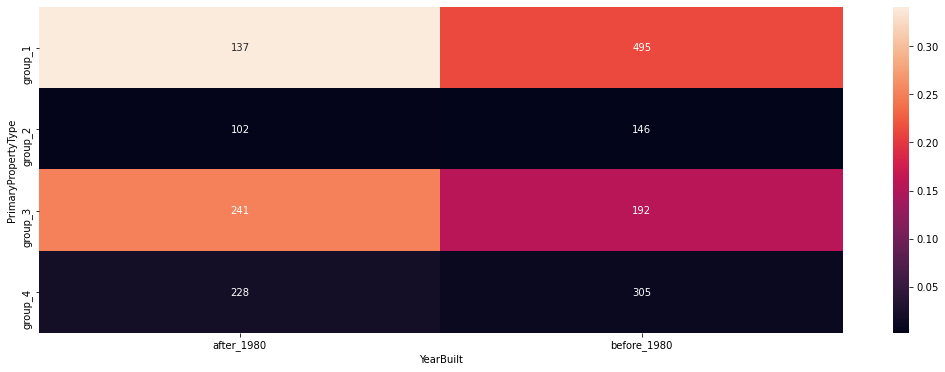

In [34]:
for dd in [d1, d2]:
    contingence("PrimaryPropertyType","YearBuilt", dd)

coefficient du chi2: 68
p-valeur: 1.4745147767019009e-06
coefficient du chi2: 11
p-valeur: 0.0034767482048598244


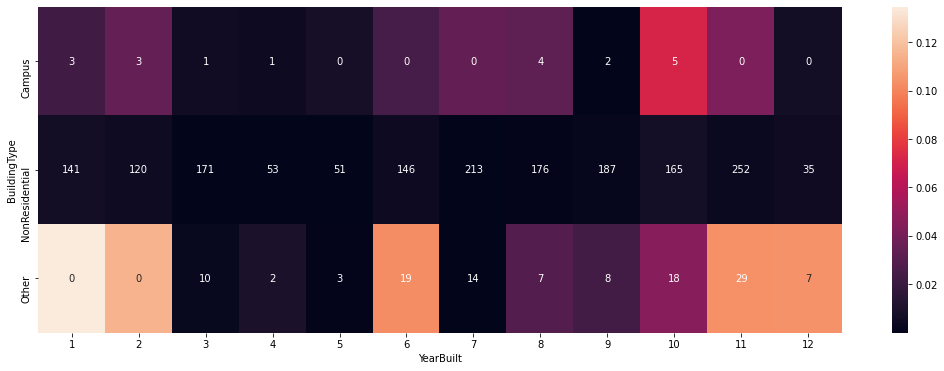

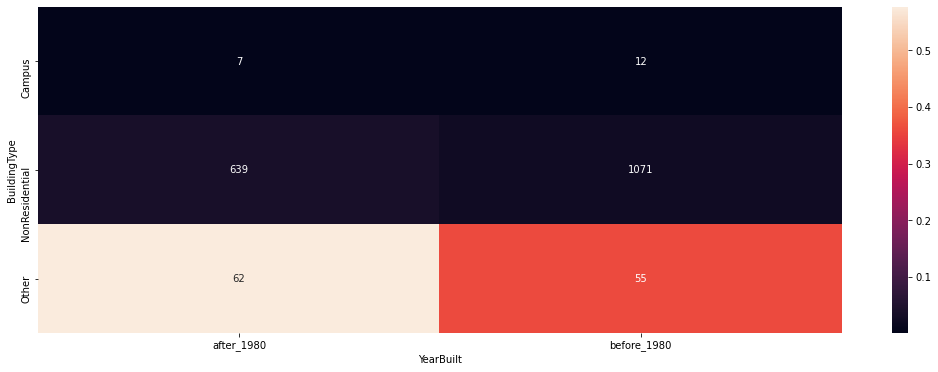

In [35]:
for dd in [d1, d2]:
    contingence("BuildingType", "YearBuilt", dd)

In [36]:
## Création de deux nouveaux jeux de données en écartant la (les) variable(s) dont l'association avec les 
## cibles est inférieure à 1% ##
d2.drop(columns=["BuildingType", "ThirdLargestPropertyUseType", "DataYear"]).to_csv("./SEUmodel3.csv", index_label=False)
d2.drop(columns=["BuildingType", "ThirdLargestPropertyUseType", "DataYear"]).to_csv("./GHGmodel3.csv", index_label=False)